In [1]:
from math import ceil
from joblib import Memory
from datetime import timedelta
import pickle
import hashlib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from mmocc.config import (
    fig_column_width,
    fig_page_width,
    golden_ratio,
    silver_ratio,
    bronze_ratio,
    default_image_backbone,
    default_sat_backbone,
    figures_path,
    image_feature_dims,
    sat_feature_dims,
    cache_path,
)
from mmocc.plot_utils import setup_matplotlib
from mmocc.train_utils import img_model_labels, sat_model_labels
from mmocc.utils import (
    get_focal_species_ids,
    powerset,
    experiment_to_filename,
    get_scientific_taxon_map,
)

setup_matplotlib()

# disable jax pre-allocation
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

figures_dir = str(figures_path)
os.makedirs(figures_dir, exist_ok=True)
use_nonlinear_regressors = False

memory = Memory(cache_path / "joblib_figures")
memory.reduce_size(age_limit=timedelta(days=30))


@memory.cache
def load_df(experiment_paths):
    df = []
    for filepath, _ in tqdm(experiment_paths):
        with open(filepath, "rb") as f:
            data = pickle.load(f)
            del data["mcmc_samples"]  # dont need to keep this in df
            df.append(data)

    df = pd.DataFrame(df)

    return df

In [2]:
image_backbones = [default_image_backbone, "visdiff_clip", "expert_clip"]
sat_backbones = [default_sat_backbone]

modalities = ["image", "sat", "covariates"]
modalities_subsets = [set(modalities)]


def get_experiment_paths(enable_cache_busting=True):
    experiment_paths = []
    for taxon_id in get_focal_species_ids():
        for modalities_subset in modalities_subsets:

            modality_image_backbones = (
                image_backbones if "image" in modalities_subset else [None]
            )
            modality_sat_backbones = (
                sat_backbones if "sat" in modalities_subset else [None]
            )
            for image_backbone in modality_image_backbones:
                for sat_backbone in modality_sat_backbones:

                    if (
                        image_backbone is not None
                        and image_backbone != default_image_backbone
                    ) and (
                        sat_backbone is not None
                        and sat_backbone != default_sat_backbone
                    ):
                        continue

                    filename = experiment_to_filename(
                        taxon_id,
                        modalities_subset,
                        image_backbone,
                        sat_backbone,
                        "pkl",
                    )
                    filepath = cache_path / "fit_results" / filename
                    if not filepath.exists():
                        print(f"Skipping missing experiment {filename}")
                        continue

                    if enable_cache_busting:
                        with open(filepath, "rb") as f:
                            hash = hashlib.md5(f.read()).hexdigest()
                    else:
                        hash = None
                    experiment_paths.append((filepath, hash))

    return experiment_paths


@memory.cache
def load_df(experiment_paths):
    df = []
    for filepath, _ in tqdm(experiment_paths):
        with open(filepath, "rb") as f:
            data = pickle.load(f)
            del data["mcmc_samples"]  # dont need to keep this in df
            df.append(data)

    df = pd.DataFrame(df)

    return df


enable_cache_busting = True
# df = load_df(get_experiment_paths(enable_cache_busting))
df = pd.read_pickle(cache_path / "figure_data_refit.pkl")
df_raw = df.copy()

# df.to_pickle(cache_path / "figure_data_refit.pkl")

df["lppd_test_norm"] = (df["lppd_test"] - df["lppd_null_test"]) / (
    df["lppd_oracle_test"] - df["lppd_null_test"]
)

df

,taxon_id,scientific_name,common_name,modalities,image_backbone,sat_backbone,limit_to_range,modalities_scaler,modalities_pca,mean_naive_occupancy_train,...,biolith_roc_auc_oracle_train,biolith_roc_auc_oracle_test,biolith_errors,best_params,clip_descriptor_texts,clip_descriptor_scores,log_likelihood_null_train,log_likelihood_null_test,log_likelihood_oracle_test,lppd_test_norm
0,00804e75-09ef-44e5-8984-85e365377d47,Antilocapra americana,pronghorn,"[covariates, image, sat]",dinov2_vitb14,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.041719,...,NaN,1.0,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",NaN,NaN,NaN,NaN,NaN,0.265572
1,00804e75-09ef-44e5-8984-85e365377d47,Antilocapra americana,pronghorn,"[covariates, image, sat]",visdiff_clip,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.041719,...,NaN,1.0,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...","[power lines across a plain, open grassland pl...","[0.9923999905586243, 0.9872000217437744, 0.986...",-0.163001,-0.097589,-0.086747,1.071732
2,00804e75-09ef-44e5-8984-85e365377d47,Antilocapra americana,pronghorn,"[covariates, image, sat]",expert_clip,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.041719,...,NaN,1.0,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",[Herbaceous (Subcanopy herbaceous vegetation g...,"[3.0, 2.0, 2.0, 2.0, 1.0]",-0.163001,-0.097589,-0.086747,1.174403
3,07843615-e1fc-49d8-9821-fd1d7ff2e773,Dasypus novemcinctus,nine-banded armadillo,"[covariates, image, sat]",dinov2_vitb14,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.220657,...,NaN,1.0,[],"{'prior_type': 'normal', 'occ_params': {'loc':...",NaN,NaN,NaN,NaN,NaN,0.071690
4,07843615-e1fc-49d8-9821-fd1d7ff2e773,Dasypus novemcinctus,nine-banded armadillo,"[covariates, image, sat]",visdiff_clip,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.220657,...,NaN,1.0,[],"{'prior_type': 'normal', 'occ_params': {'loc':...","[thick leaf litter covering the ground, leaf l...","[0.996399998664856, 0.9959999918937683, 0.9951...",-0.296248,-0.444961,-0.326345,0.170306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,febff896-db40-4ac8-bcfe-5bb99a600950,Odocoileus hemionus,mule deer,"[covariates, image, sat]",dinov2_vitb14,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.171047,...,NaN,1.0,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",NaN,NaN,NaN,NaN,NaN,-0.332491
62,febff896-db40-4ac8-bcfe-5bb99a600950,Odocoileus hemionus,mule deer,"[covariates, image, sat]",visdiff_clip,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.171047,...,NaN,1.0,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...","[a dirt road in a desert, dirt road, arid dese...","[0.7820000052452087, 0.7803999781608582, 0.745...",-0.465536,-0.403245,-0.270664,-0.541724
63,febff896-db40-4ac8-bcfe-5bb99a600950,Odocoileus hemionus,mule deer,"[covariates, image, sat]",expert_clip,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.171047,...,NaN,1.0,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",[Shrubs (Woody plants of smaller stature than ...,"[3.0, 3.0, 2.0, 2.0, 2.0]",-0.465536,-0.403245,-0.270664,-0.575865
64,ffe603fc-4920-4302-96d0-65f708bd5b2d,Urocyon cinereoargenteus,grey fox,"[covariates, image, sat]",dinov2_vitb14,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.061603,...,NaN,1.0,[],"{'prior_type': 'laplace', 'occ_params': {'loc

In [3]:
min_occupancy = 0.1  # TODO
low_occupancy_mask = df["mean_naive_occupancy_test"] < min_occupancy
print(
    f"Removing {df[low_occupancy_mask]['taxon_id'].nunique()} species with low occupancy (< 0.1)"
)
df = df[df["mean_naive_occupancy_test"] >= min_occupancy]

Removing 9 species with low occupancy (< 0.1)


### Compare descriptor-driven refits against the baseline

Benchmark VisDiff and expert CLIP descriptors against the default image backbone.

In [4]:
comparison_metrics = [
    "lppd_test_norm",
    "biolith_ap_test",
    "biolith_roc_auc_test",
    "lr_map_test",
    "lr_mcc_test",
]


def align_backbone(backbone: str) -> pd.DataFrame:
    return df[df["image_backbone"] == backbone].set_index("taxon_id")[
        ["scientific_name", *comparison_metrics]
    ]


baseline_df = align_backbone(default_image_backbone)
visdiff_df = align_backbone("visdiff_clip")
expert_df = align_backbone("expert_clip")


def summarize_against_baseline(target: pd.DataFrame, label: str) -> pd.DataFrame:
    overlap = baseline_df.index.intersection(target.index)
    merged = (
        baseline_df.loc[overlap, comparison_metrics]
        .add_suffix("_baseline")
        .join(target.loc[overlap, comparison_metrics].add_suffix(f"_{label}"))
    )
    rows = []
    for metric in comparison_metrics:
        deltas = merged[f"{metric}_{label}"] - merged[f"{metric}_baseline"]
        rows.append(
            {
                "metric": metric,
                "n_species": len(deltas),
                "mean_delta": deltas.mean(),
                "median_delta": deltas.median(),
                "improved_%": 100 * (deltas > 0).mean(),
            }
        )
    return pd.DataFrame(rows)


visdiff_vs_baseline = summarize_against_baseline(visdiff_df, "visdiff")
expert_vs_baseline = summarize_against_baseline(expert_df, "expert")

visdiff_vs_baseline.round(3), expert_vs_baseline.round(3)

(                 metric  n_species  mean_delta  median_delta  improved_%
 0        lppd_test_norm         18      -0.050        -0.023      38.889
 1       biolith_ap_test         18      -0.031        -0.028      22.222
 2  biolith_roc_auc_test         18      -0.024        -0.020      11.111
 3           lr_map_test         18      -0.029        -0.031      22.222
 4           lr_mcc_test         18      -0.007        -0.019      27.778,
                  metric  n_species  mean_delta  median_delta  improved_%
 0        lppd_test_norm          8      -0.150        -0.140        12.5
 1       biolith_ap_test          8      -0.057        -0.054         0.0
 2  biolith_roc_auc_test          8      -0.062        -0.052         0.0
 3           lr_map_test          8      -0.053        -0.041        12.5
 4           lr_mcc_test          8      -0.017        -0.038        25.0)

/tmp/ipykernel_339159/209692129.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


,backbone,scientific_name,delta,baseline,target
104,expert,Sciurus niger,-0.002,0.483,0.481
103,expert,Lynx rufus,-0.010,0.329,0.319
101,expert,Canis latrans,-0.035,0.507,0.473
102,expert,Vulpes vulpes,-0.038,0.391,0.353
98,expert,Sciurus griseus,-0.070,0.368,0.298
23,visdiff,Pecari tajacu,0.067,0.348,0.415
18,visdiff,Dasypus novemcinctus,0.005,0.432,0.437
32,visdiff,Lynx rufus,0.005,0.329,0.334
22,visdiff,Ursus americanus,0.003,0.361,0.365
24,visdiff,Odocoileus virginianus,-0.006,0.942,0.936


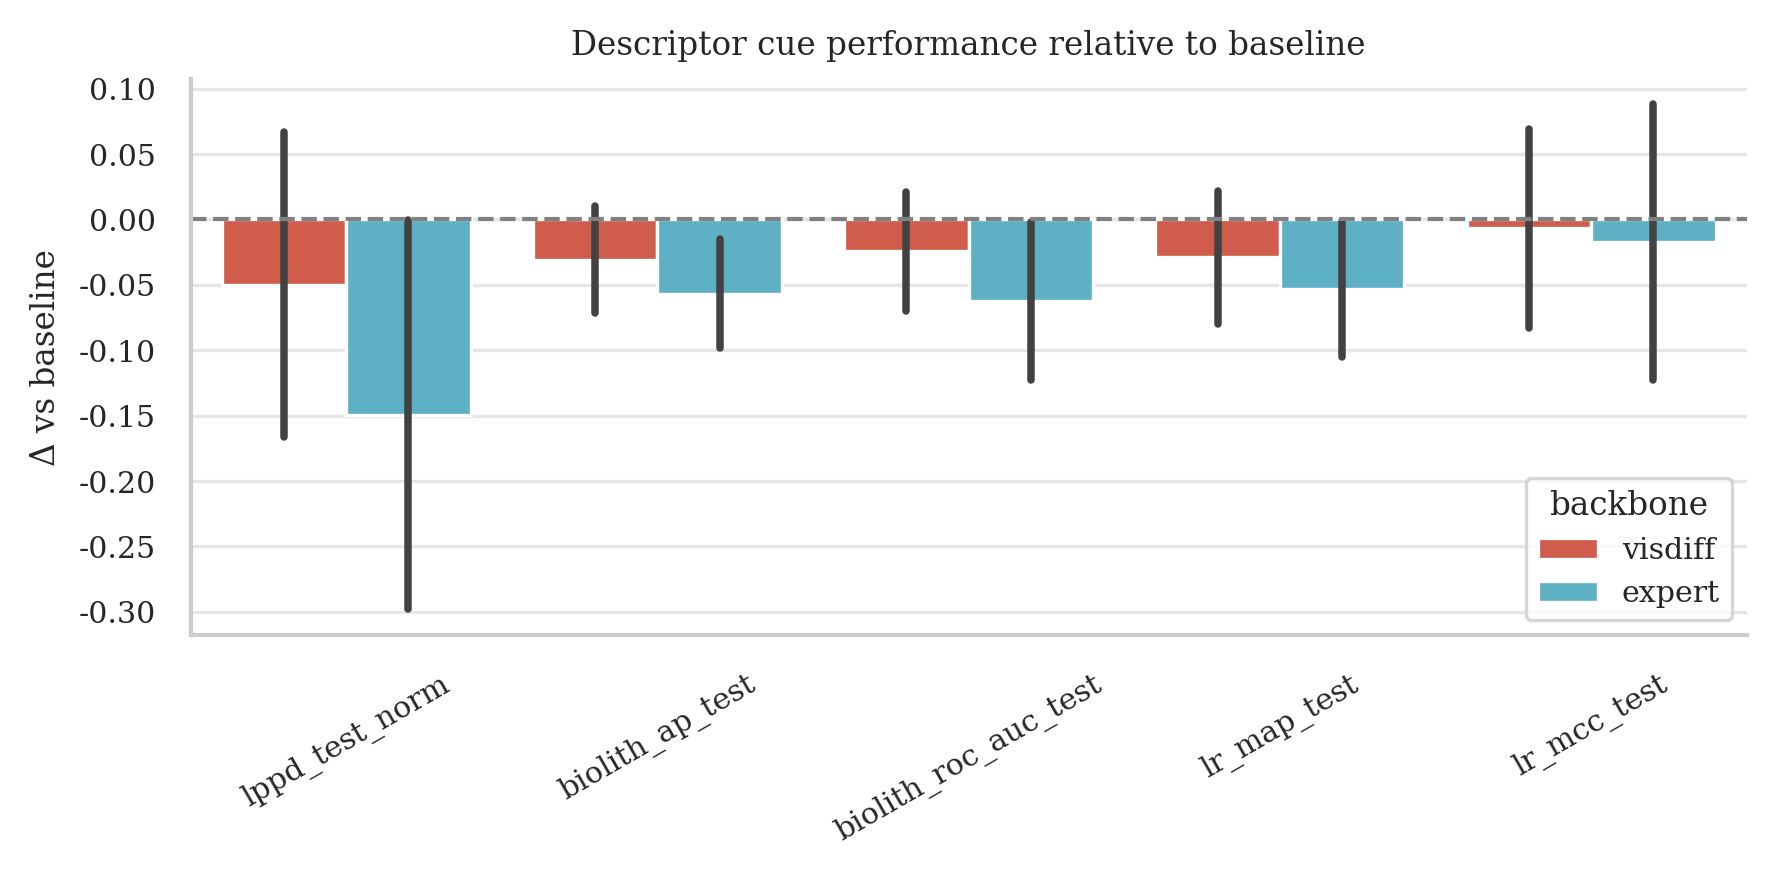

In [5]:
def build_delta_table(target: pd.DataFrame, label: str) -> pd.DataFrame:
    overlap = baseline_df.index.intersection(target.index)
    merged = (
        baseline_df.loc[overlap, ["scientific_name", *comparison_metrics]]
        .rename_axis("taxon_id")
        .join(
            target.loc[overlap, comparison_metrics],
            lsuffix="_baseline",
            rsuffix=f"_{label}",
        )
    )
    records = []
    for metric in comparison_metrics:
        deltas = merged[f"{metric}_{label}"] - merged[f"{metric}_baseline"]
        for taxon_id, delta in deltas.items():
            records.append(
                {
                    "taxon_id": taxon_id,
                    "scientific_name": merged.loc[taxon_id, "scientific_name"],
                    "metric": metric,
                    "backbone": label,
                    "delta": delta,
                    "baseline": merged.loc[taxon_id, f"{metric}_baseline"],
                    "target": merged.loc[taxon_id, f"{metric}_{label}"],
                }
            )
    return pd.DataFrame(records)


delta_long = pd.concat(
    [
        build_delta_table(visdiff_df, "visdiff"),
        build_delta_table(expert_df, "expert"),
    ],
    ignore_index=True,
)

subset = delta_long[delta_long["metric"] == "biolith_ap_test"]
top_improvements = (
    subset.sort_values(["backbone", "delta"], ascending=[True, False])
    .groupby("backbone")
    .head(5)
    .loc[:, ["backbone", "scientific_name", "delta", "baseline", "target"]]
)

fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(
    data=delta_long,
    x="metric",
    y="delta",
    hue="backbone",
    estimator=np.mean,
    errorbar="sd",
    ax=ax,
)
ax.axhline(0, color="gray", linewidth=1, linestyle="--")
ax.set_ylabel("Δ vs baseline")
ax.set_xlabel("")
ax.set_title("Descriptor cue performance relative to baseline")
ax.tick_params(axis="x", rotation=30)
fig.tight_layout()

top_improvements.round(3)

/tmp/ipykernel_339159/3674678678.py:38: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
2026-01-22 14:49:43,614 INFO maxp pruned
2026-01-22 14:49:43,619 INFO cmap pruned
2026-01-22 14:49:43,624 INFO kern dropped
2026-01-22 14:49:43,624 INFO post pruned
2026-01-22 14:49:43,625 INFO FFTM dropped
2026-01-22 14:49:43,626 INFO GPOS pruned
2026-01-22 14:49:43,627 INFO GSUB pruned
2026-01-22 14:49:43,629 INFO glyf pruned
2026-01-22 14:49:43,629 INFO Added gid0 to subset
2026-01-22 14:49:43,629 INFO Added first four glyphs to subset
2026-01-22 14:49:43,629 INFO Closing glyph list over 'MATH': 29 glyphs before
2026-01-22 14:49:43,630 INFO Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'E', 'I', 'L', 'P', 'V', 'a', 'e', 'f', 'four', 'hyphen', 'i', 'l', 'n', 'nonmarkingreturn', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'x', 'zero']
2026-01-22 14:49:43,630 INFO Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 21, 23, 25, 37, 38, 39, 40, 44, 47, 51, 57, 68, 72, 73, 76, 79

Average improvement in LPPD (normalized): -0.050 (VisDiff), -0.150 (Expert)


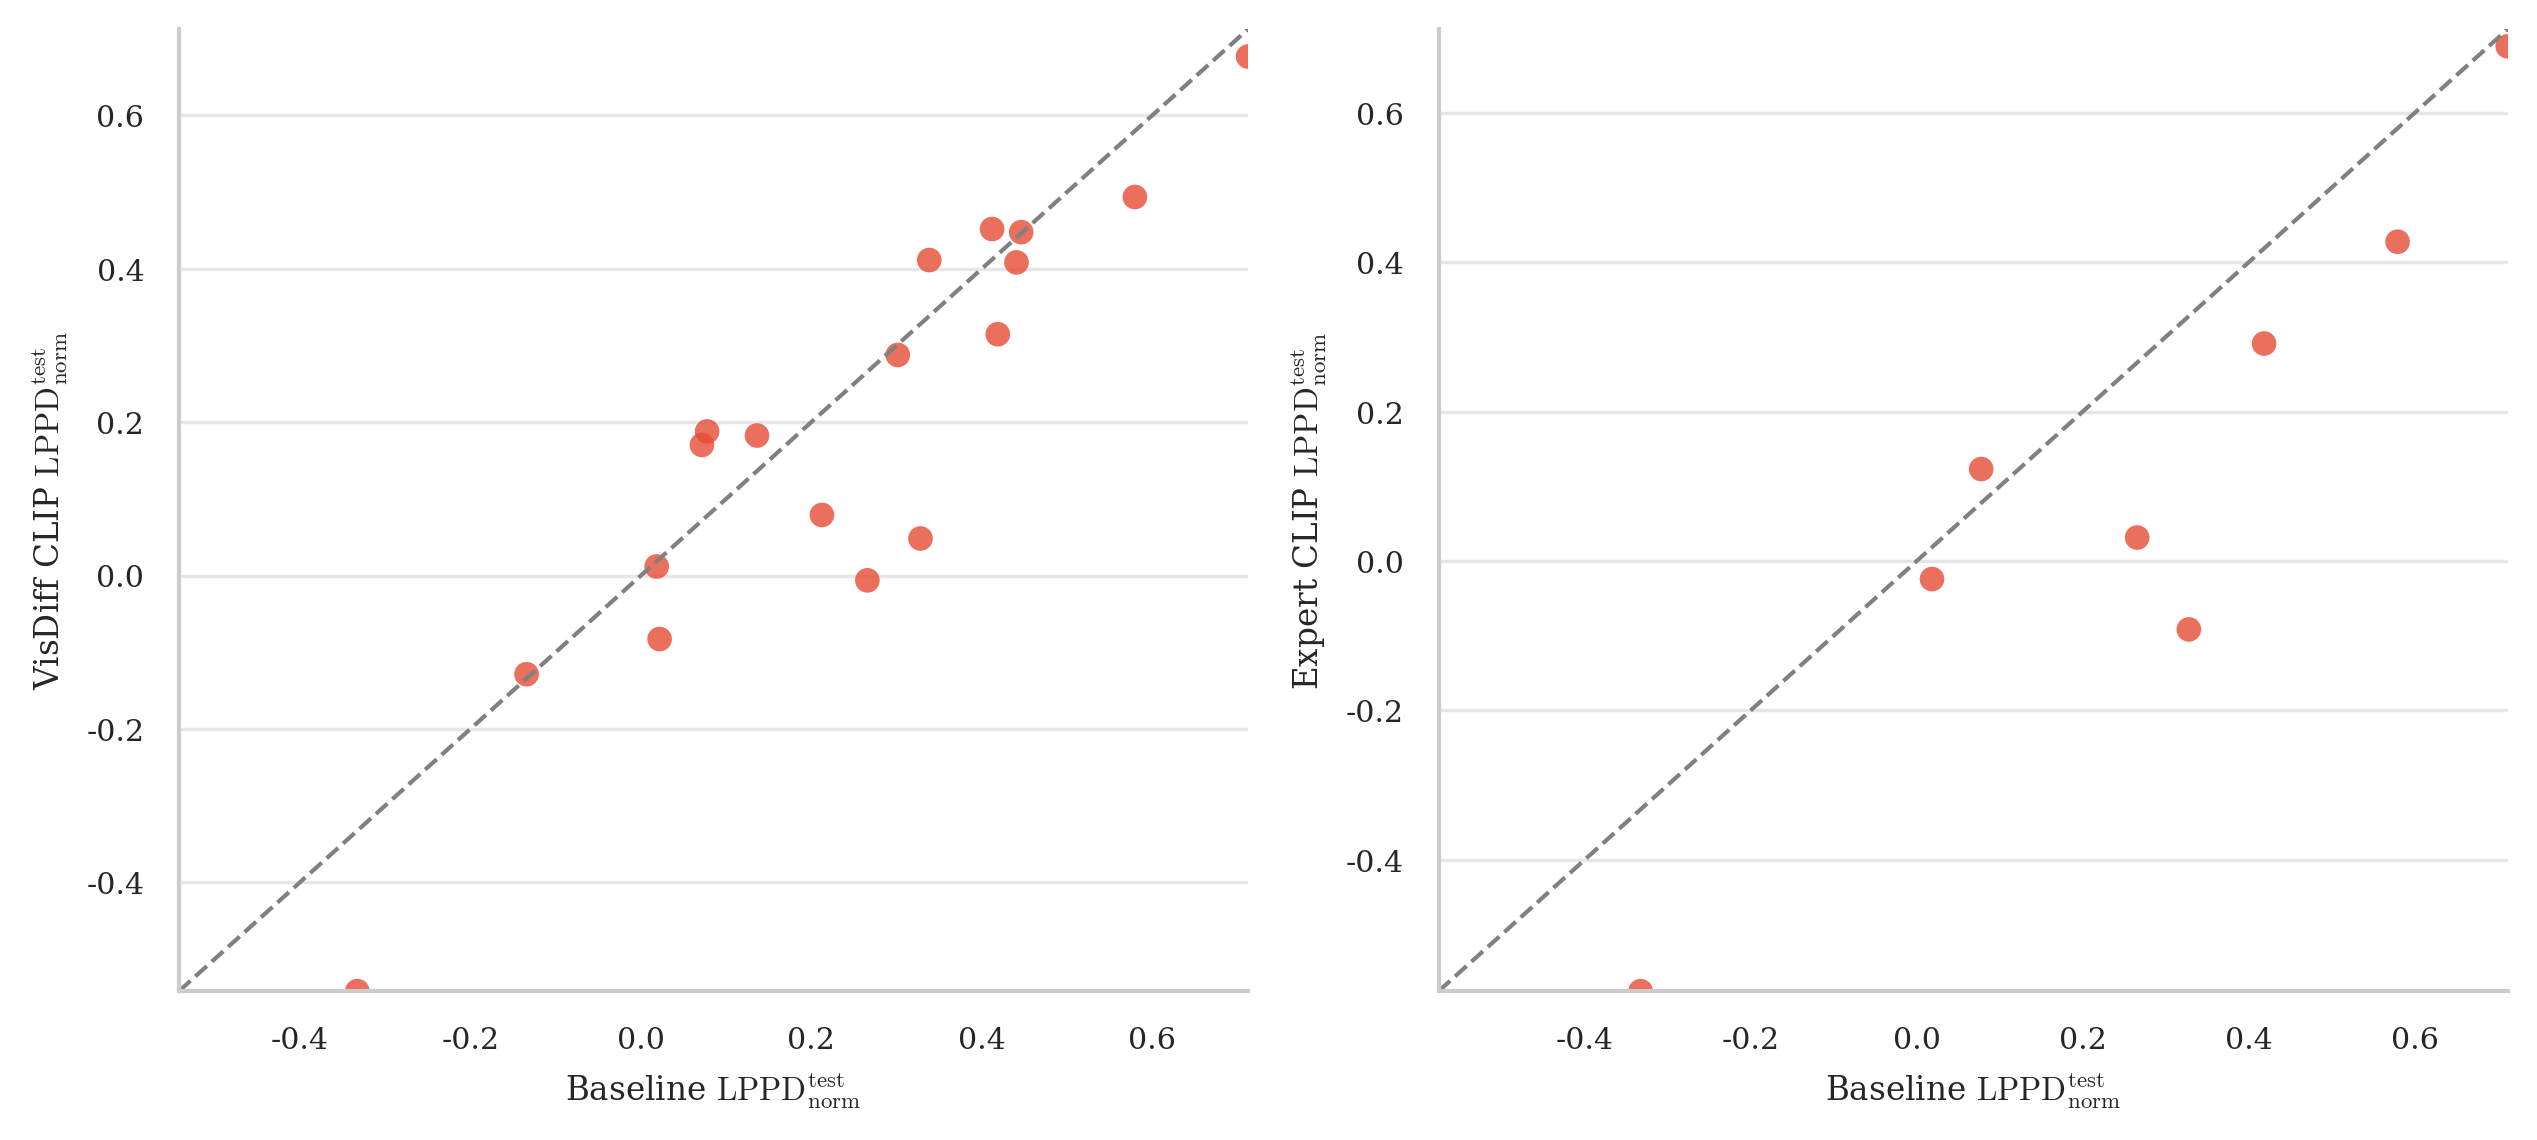

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(fig_page_width, fig_page_width / 2.2))

plot_specs = [
    ("VisDiff vs baseline", visdiff_df, "VisDiff CLIP"),
    ("Expert vs baseline", expert_df, "Expert CLIP"),
]

for ax, (title, target_df, label) in zip(axes, plot_specs):
    overlap = baseline_df.index.intersection(target_df.index)
    scatter_data = (
        baseline_df.loc[overlap, ["scientific_name", "lppd_test_norm"]]
        .rename(columns={"lppd_test_norm": "baseline"})
        .join(
            target_df.loc[overlap, ["lppd_test_norm"]].rename(
                columns={"lppd_test_norm": "target"}
            )
        )
    )

    ax.scatter(
        scatter_data["baseline"],
        scatter_data["target"],
        s=35,
        alpha=0.8,
        edgecolor="none",
    )

    lims = [
        np.nanmin(scatter_data[["baseline", "target"]].values),
        np.nanmax(scatter_data[["baseline", "target"]].values),
    ]
    ax.plot(lims, lims, linestyle="--", color="gray", linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(r"Baseline $\text{LPPD}_\text{norm}^\text{test}$")
    ax.set_ylabel(label + r" $\text{LPPD}_\text{norm}^\text{test}$")

fig.tight_layout()
fig.savefig(
    f"{figures_dir}/refit_lppd_comparison.pdf", bbox_inches="tight", transparent=True
)

print(
    f"Average improvement in LPPD (normalized): {visdiff_vs_baseline[visdiff_vs_baseline['metric']=='lppd_test_norm']['mean_delta'].values[0]:.3f} (VisDiff), {expert_vs_baseline[expert_vs_baseline['metric']=='lppd_test_norm']['mean_delta'].values[0]:.3f} (Expert)"
)

In [7]:
df.iloc[df["lppd_test_norm"].argmin()].to_dict()

{'taxon_id': 'febff896-db40-4ac8-bcfe-5bb99a600950',
 'scientific_name': 'Odocoileus hemionus',
 'common_name': 'mule deer',
 'modalities': ['covariates', 'image', 'sat'],
 'image_backbone': 'expert_clip',
 'sat_backbone': 'alphaearth',
 'limit_to_range': True,
 'modalities_scaler': {'covariates': StandardScaler(),
  'image': StandardScaler(),
  'sat': StandardScaler()},
 'modalities_pca': {'covariates': PCA(n_components=26),
  'image': PCA(n_components=5),
  'sat': PCA(n_components=64)},
 'mean_naive_occupancy_train': 0.17104714226115977,
 'mean_naive_occupancy_test': 0.2707948243992606,
 'naive_detection_prob_train': 0.7152495537699985,
 'naive_detection_prob_test': 0.46767153244266274,
 'mean_num_observations_train': 0.17375565610859728,
 'mean_num_observations_test': 0.13896699718810124,
 'mean_num_nonnan_train': 8840,
 'mean_num_nonnan_test': 6757,
 'test_sites_too_close': 1858,
 'lr_mcc_test': -0.32232617712834816,
 'lr_precision_test': 0.0990990990990991,
 'lr_recall_test': 0.15